# Associations between microbial presence/absence and patient info

In [1]:
setwd("/mnt/c/git_repos/blood_microbial_signatures/")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(doParallel)
require(ggrepel)
registerDoParallel(cores = 8)


Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning messa

### Load  data

In [8]:
X <- fread("results/decontamination/prevalence_RA0.005_read10.csv")
nc <- fread("results/decontamination/curated_n117_global_decontamination_stats.csv")
X <- X %>% select(all_of(c("npm_research_id", nc$taxa)))

meta <- fread("data/20210125_v3_release/20210203_all_traits_v3.txt")
meta2 <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")

n <- gsub("[^0-9A-Za-z///' ]", " ", colnames(meta))
n <- tolower(n)
n <- gsub(" ", "_", n)
colnames(meta) <- n

fwrite(meta, "data/20210125_v3_release/20210203_all_traits_v3.parsed.csv")

### Remove samples where blood collection for sequencing date != biomarker collection date

In [9]:
X_meta <- X %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    filter(date_blood == date_biomarker) %>%
    filter(date_blood != "",
           !is.na(date_blood),
           !is.na(date_biomarker),
           date_biomarker != "") %>%
    as_tibble()
dim(X_meta)

[1] 7834  235

In [10]:
taxon_list <- colSums(X[, 2:ncol(X)]) >= 50
taxon_list <- names(taxon_list[taxon_list])
length(taxon_list)
taxon_list

[1] 11

[1] "Cutibacterium acnes"          "Human mastadenovirus C"      
 [3] "Staphylococcus epidermidis"   "Lactobacillus crispatus"     
 [5] "Moraxella osloensis"          "Gardnerella vaginalis"       
 [7] "Mycolicibacterium aubagnense" "Lactobacillus iners"         
 [9] "Phyllobacterium zundukense"   "Acidovorax sp. KKS102"       
[11] "Bifidobacterium adolescentis"

In [11]:
# Get variable lists
taxon_list <- colSums(X[, 2:ncol(X)]) >= 50
taxon_list <- names(taxon_list[taxon_list])
length(taxon_list)

categorical_list_full <- c("fasting", "genetic_sex", "genetic_ancestry", 
                      "diab_med", "htn_med", "lipid_med", "t2d")
cont_list_full <- c("age", "bmi", 
               "height_cm", "weight_kg", "waistc_cm", "hipc_cm", 
               "tc_mmol_l", "ldl_direct_mmol_l", "hdl_mmol_l", "tg_mmol_l",
               "glu_fast_mmol_l", "ins_fast_uiu_ml", "glu_rand_mmol_l",
               "ldl_cal_mmol_l",              
               "sbp", "dbp")

categorical_list <- c("genetic_sex", "genetic_ancestry")
cont_list <- c("age", "bmi", "tc_mmol_l", "tg_mmol_l", 
               "sbp", "dbp")

[1] 11

In [12]:
cohort_list <- unique(X_meta$site_supplying_sample)
# cohort_list <- cohort_list[cohort_list != "SSMP"]
cohort_list

n_comparisons <- length(cohort_list) * length(taxon_list) * (length(categorical_list) + length(cont_list))
n_comparisons

[1] "MEC"    "HELIOS" "SEED"   "PRISM"  "TTSH"

[1] 440

### Basic stats on phenotypes

In [13]:
n_df <- X_meta %>%
    select(npm_research_id, site_supplying_sample) %>%
    group_by(site_supplying_sample) %>%
    summarise(cohort_total = n())

plot_list <- foreach (col = categorical_list_full) %do% {
X_meta %>%
        group_by_at(c(col, "site_supplying_sample")) %>%
        summarise(count = n()) %>%
        left_join(n_df) %>%
        mutate(col = factor(get(col), levels = unique(get(col)))) %>%
        ggplot(aes(x = site_supplying_sample, y = count, fill = col)) +
            geom_bar(position = "stack", stat = "identity") +
            theme(legend.position = "top") +
            geom_text(aes(x = site_supplying_sample, y = -3, label = paste0("n = ", cohort_total)),
                      vjust = 0) +
            labs(fill = col)
}

plot_list2 <- foreach (col = cont_list_full) %do% {
    X_meta %>%
        left_join(n_df) %>%
        ggplot(aes_string(x = "site_supplying_sample", y = col, fill = "genetic_sex")) +
            geom_boxplot() +
            theme(legend.position = "top") +
            geom_text(aes(x = site_supplying_sample, y = -3, label = paste0("n = ", cohort_total)),
                      vjust = 0) +
            labs(y = col)
}

plot_list <- c(plot_list, plot_list2)
pdf("results/phenotype_associations/metadata_barcharts2.pdf")
for (plt in plot_list) {
    print(plt)
}
dev.off()

`summarise()` has grouped output by 'fasting'. You can override using the `.groups` argument.
Joining with `by = join_by(site_supplying_sample)`
`summarise()` has grouped output by 'genetic_sex'. You can override using the `.groups` argument.
Joining with `by = join_by(site_supplying_sample)`
`summarise()` has grouped output by 'genetic_ancestry'. You can override using the `.groups` argument.
Joining with `by = join_by(site_supplying_sample)`
`summarise()` has grouped output by 'diab_med'. You can override using the `.groups` argument.
Joining with `by = join_by(site_supplying_sample)`
`summarise()` has grouped output by 'htn_med'. You can override using the `.groups` argument.
Joining with `by = join_by(site_supplying_sample)`
`summarise()` has grouped output by 'lipid_med'. You can override using the `.groups` argument.
Joining with `by = join_by(site_supplying_sample)`
`summarise()` has grouped output by 't2d'. You can override using the `.groups` argument.
Joining with `by = join_

png 
  2

In [47]:
cont <- "tg_mmol_l"
taxon <- "Moraxella osloensis"
X_meta_filt <- X_meta %>% 
            filter(!is.na(get(cont)),
                   site_supplying_sample == cohort)
        var_vec <- deframe(X_meta_filt[, cont])
        species_vec <- deframe(X_meta_filt[, taxon])

# tibble(phen = var_vec, spec = species_vec) %>%
#     ggplot(aes(y = log10(phen), x = spec)) +
#     geom_violin() +
#     ggpubr::stat_compare_means()
lt <- car::leveneTest(var_vec ~ species_vec)
tibble(lt) %>%
    select(leveneTest_F_stat = "F value", leveneTest_pval = "Pr(>F)") %>%
    filter(!is.na(leveneTest_F_stat))

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


leveneTest_F_stat,leveneTest_pval
<dbl>,<dbl>
0.08859253,0.766069


In [48]:
cont_list
morsels <- foreach(cohort = cohort_list) %do% {
    # For continuous variables
    cont_morsels <- foreach (cont = cont_list) %dopar% {
        X_meta_filt <- X_meta %>% 
            filter(!is.na(get(cont)),
                   site_supplying_sample == cohort)
        var_vec <- deframe(X_meta_filt[, cont])

        foreach (taxon = taxon_list) %do% {
            species_vec <- deframe(X_meta_filt[, taxon])
            
            if(sum(species_vec) > 0) {
                # Test for equality of variances
                lt <- car::leveneTest(var_vec ~ species_vec)
                lt_results <- tibble(lt) %>%
                    select(leveneTest_F_stat = "F value", leveneTest_pval = "Pr(>F)") %>%
                    filter(!is.na(leveneTest_F_stat))
                test <- wilcox.test(var_vec ~ species_vec, correct = F, alternative = "two.sided") 
                return(tibble(taxa = taxon, variable = cont, 
                              U = test$statistic, 
                              p = test$p.value,
                              leveneTest_F_stat = lt_results$leveneTest_F_stat,
                              leveneTest_pval = lt_results$leveneTest_pval))
            } else {
                return(tibble(taxa = taxon, variable = cont, 
                              U = NA, 
                              p = NA,
                              leveneTest_F_stat = NA,
                              leveneTest_pval = NA))
            }
        }
    }

    cont_res <- bind_rows(cont_morsels)

    res_temp <- cat_res %>%
        bind_rows(cont_res) %>%
        add_column(cohort = cohort)
    res_temp
}

res <- bind_rows(morsels)

[1] "age"       "bmi"       "tc_mmol_l" "tg_mmol_l" "sbp"       "dbp"

In [59]:
res_filt <- res %>% 
    filter(!is.na(leveneTest_pval))

res_filt %>%
    mutate(leveneTest_pval_corr = p.adjust(leveneTest_pval, method = "BH", n = nrow(res_filt))) %>%
    summarise(round(range(leveneTest_F_stat), 2))


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”


"round(range(leveneTest_F_stat), 2)"
<dbl>
0.00
13.29


## Phenotype association tests

In [14]:
morsels <- foreach(cohort = cohort_list) %do% {
    cat_morsels <- foreach (category = categorical_list) %dopar% {
        X_meta_filt <- X_meta %>% 
            filter(!is.na(get(category)),
                   site_supplying_sample == cohort)
        var_vec <- deframe(X_meta_filt[, category])

        foreach (taxon = taxon_list) %do% {
            species_vec <- deframe(X_meta_filt[, taxon])

            if(sum(species_vec) > 0 & length(unique(var_vec)) >= 2) {
                test <- fisher.test(var_vec, species_vec)
                return(tibble(taxa = taxon, variable = category, OR = test$estimate, p = test$p.value))
            } else {
                return(tibble(taxa = taxon, variable = category, OR = NA, p = NA))
            }
        }
    }

    cat_res <- bind_rows(cat_morsels)

    # For continuous variables
    cont_morsels <- foreach (cont = cont_list) %dopar% {
        X_meta_filt <- X_meta %>% 
            filter(!is.na(get(cont)),
                   site_supplying_sample == cohort)
        var_vec <- deframe(X_meta_filt[, cont])

        foreach (taxon = taxon_list) %do% {
            species_vec <- deframe(X_meta_filt[, taxon])

            if(sum(species_vec) > 0) {
                test <- wilcox.test(var_vec ~ species_vec, correct = F, alternative = "two.sided") 
                return(tibble(taxa = taxon, variable = cont, 
                              U = test$statistic, 
                              p = test$p.value))
            } else {
                return(tibble(taxa = taxon, variable = cont, 
                                          U = NA, 
                                          p = NA))
            }
        }
    }

    cont_res <- bind_rows(cont_morsels)

    res_temp <- cat_res %>%
        bind_rows(cont_res) %>%
        add_column(cohort = cohort)
    res_temp
}

res <- bind_rows(morsels)

In [9]:
n_not_tested <- res %>%
    filter(is.na(p)) %>%
    nrow()

n_comparisons_final <- n_comparisons - n_not_tested
print(n_comparisons_final)
a <- 0.05

res_filt <- res %>%
    filter(!is.na(p)) %>%
    mutate(p.adj = p.adjust(p, "BH", n = n_comparisons_final)) %>%
    mutate(log_p_adj = -log(p.adj, base = 10),
           annot = ifelse(log_p_adj > 5, taxa, ""),
           variable = case_when(variable == "genetic_ancestry" ~ "Ancestry",
                                variable == "age" ~  "Age",
                                variable == "tg_mmol_l" ~ "Triglycerides",
                                variable == "bmi" ~ "BMI",
                                variable == "tc_mmol_l" ~ "Total cholesterol",
                                variable == "genetic_sex" ~ "Sex",
                                variable == "sbp" ~ "SBP",
                                variable == "dbp" ~ "DBP"),
           color_value = ifelse(p.adj > a, NA, log_p_adj))

[1] 258


In [10]:
res_filt %>% 
    filter(p.adj < 0.05) %>%
    group_by(taxa, variable) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

`summarise()` has grouped output by 'taxa'. You can override using the `.groups` argument.


taxa,variable,n
<chr>,<chr>,<int>
Cutibacterium acnes,Ancestry,2
Human mastadenovirus C,Age,1
Human mastadenovirus C,Triglycerides,1
Moraxella osloensis,Ancestry,1


In [11]:
final <- res_filt %>% 
    filter(p.adj < 0.05)
final
fwrite(final, "results/phenotype_associations/phenotype_association_results_simple_single_cohorts.csv")

taxa,variable,OR,p,U,cohort,p.adj,log_p_adj,annot,color_value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Cutibacterium acnes,Ancestry,NA,3.964819e-04,NA,MEC,2.557308e-02,1.592217,,1.592217
Human mastadenovirus C,Age,NA,1.397409e-07,179195.5,MEC,3.605314e-05,4.443057,,4.443057
Human mastadenovirus C,Triglycerides,NA,5.712072e-04,164767.0,MEC,2.947429e-02,1.530557,,1.530557
Cutibacterium acnes,Ancestry,NA,7.306438e-06,NA,SEED,9.425305e-04,3.025705,,3.025705
Moraxella osloensis,Ancestry,NA,6.982654e-05,NA,SEED,6.005083e-03,2.221481,,2.221481


### Plot prevalence for ancestry

`summarise()` has grouped output by 'genetic_ancestry'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'genetic_ancestry'. You can override using the `.groups` argument.
Joining with `by = join_by(genetic_ancestry, site_supplying_sample)`


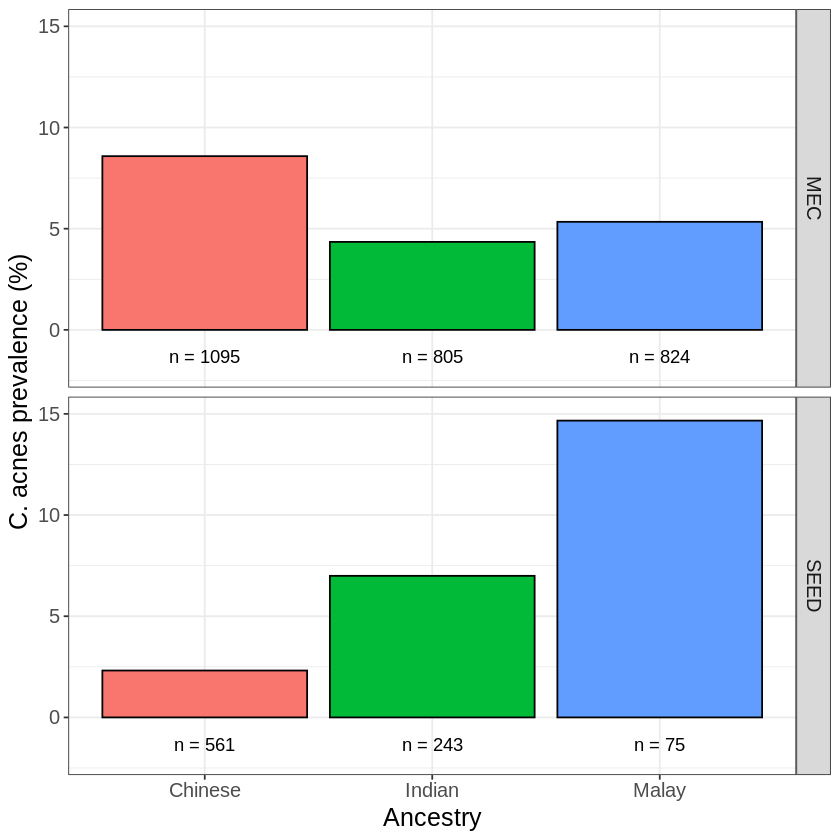

In [14]:
taxon <- "Cutibacterium acnes"
n_df <- X_meta %>%
    group_by(genetic_ancestry, site_supplying_sample) %>%
    summarise(n_total = n())

cohorts_of_interest <- final %>% 
    filter(taxa == taxon)
cohorts_of_interest <- unique(cohorts_of_interest$cohort)

plot_df <- X_meta %>%
    filter(site_supplying_sample %in% cohorts_of_interest) %>%
    filter(!is.na(genetic_ancestry)) %>%
    select(all_of(c(taxon, "genetic_ancestry", "site_supplying_sample"))) %>%
    pivot_longer(!c(genetic_ancestry, site_supplying_sample), names_to = "site", values_to = "presence") %>%
    group_by(genetic_ancestry, site_supplying_sample) %>%
    summarise(n = sum(presence)) %>%
    left_join(n_df) %>%
    mutate(prop = n / n_total,
           genetic_ancestry = case_when(genetic_ancestry == "C" ~ "Chinese",
                                        genetic_ancestry == "M" ~ "Malay",
                                        genetic_ancestry == "I" ~ "Indian",
                                        genetic_ancestry == "O" ~ "Others"),
           site_supplying_sample = ifelse(site_supplying_sample == "SERI", "SEED", site_supplying_sample))

plot_df %>% fwrite(str_glue("results/figure_source_data_nat_micro/{taxon_save_name}.genetic_ancestry.csv"))

plot_df %>%
    ggplot(aes(x = genetic_ancestry, y = prop * 100, fill = genetic_ancestry)) +
        facet_grid(rows = vars(site_supplying_sample)) +
        geom_bar(stat = "identity", 
                 position = "dodge",
                 color = "black") +
        labs(x = "Ancestry", y = "C. acnes prevalence (%)") +
        geom_text(aes(y = -1, label = paste0("n = ", n_total)),
                  vjust = 1,
                  color = "black") +
        theme_bw() +
        theme(legend.position = "none",
              text = element_text(size = 15)) +
        ylim(-2, 15)

taxon_save_name <- paste0(taxon, collapse = "_")
ggsave(str_glue("results/phenotype_associations/separate_simple_plots/{taxon_save_name}.genetic_ancestry.pdf"), 
       width = 10, height = 6)

### Iterate across all significant hits

In [ ]:
sig_list <- (res_filt %>%
    filter(p.adj < 0.05) %>%
    distinct(taxa))$taxa
for (taxon in sig_list) {
    X_meta %>%
            select(all_of(c(taxon, "genetic_ancestry", "site_supplying_sample"))) %>%
            pivot_longer(!c(genetic_ancestry, site_supplying_sample), names_to = "site", values_to = "presence") %>%
            group_by(genetic_ancestry, site_supplying_sample) %>%
            summarise(n = sum(presence)) %>%
            left_join(n_df2) %>%
            mutate(prop = n / n_total) %>%
            ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry)) +
                facet_grid(rows = vars(site_supplying_sample)) +
                geom_bar(stat = "identity", position = "dodge") +
                labs(x = "genetic_ancestry", y = "Prop. of positive samples") +
                geom_text(aes(y = prop, label = n),
                          vjust = 0,
                          color = "red") +
                geom_text(aes(y = -0.01, label = paste0("n_sampled = ", n_total)),
                          vjust = 1,
                          color = "black") +
    ylim(-0.1, 0.6)
        taxon_save_name <- paste0(taxon, collapse = "_")
        ggsave(str_glue("results/phenotype_associations/separate_simple_plots/{taxon_save_name}.genetic_ancestry.png"), 
               width = 15, height = 7)
}